# Astro M33

This notebook analyzes astronomy spectra data for age characteristics for chemically peculiar / non-chemically peculiar stars.

## Setup

Do the imports and create the spark session instance.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd

spark = SparkSession.builder \
    .appName("Astro") \
    .enableHiveSupport() \
    .getOrCreate()

## Ingest

This function copies the astronomy data to a managed table. This will take some time (and disk space), but it only needs to be done once ever for the entire dataset, and it will speed up any future analysis. Any future runs of ingest() will be ignored (silently fail) due to the table already existing.

To re-ingest, one must first run this to delete the data:
```python
spark.sql('drop table astro')
```

In [2]:
# Uncomment to delete the table if necessary
# spark.sql('drop table astro')

In [3]:
def ingest():
    if "astro" in [t.name for t in spark.catalog.listTables("default")]:
        print('Table "astro" already exists. Ignoring.')
        return
    raw = spark.read.text("../data/*/*/hmix.*")
    raw_filtered = raw.select( \
            input_file_name().alias('filename'), \
            col('value').alias('raw') \
        ) \
        .filter(~col('value').startswith('#'))
    
    cleaned = raw_filtered \
        .select( \
            split(col('filename'), '/').alias('fn_split'), \
            split(trim(col('raw')), '  ', 2).alias('raw_split') \
        ) \
        .select( \
            element_at(col('fn_split'), -3).alias('dataset'), \
            element_at(col('fn_split'), -2).alias('cp_str'), \
            element_at(col('fn_split'), -1).alias('fn'), \
            col('raw_split')[0].cast('float').alias('wavelength'), \
            col('raw_split')[1].cast('float').alias('flam') \
        ) \
        .select( \
            col('dataset'), \
            when(col('cp_str') == 'cp', 1).otherwise(0).alias('is_cp'), \
            substring(col('fn'), 7, 6).cast('bigint').alias('age_mil'), \
            substring(col('fn'), 14, 4).cast('int').alias('heavy_metal_c'), \
            col('wavelength'), \
            col('flam') \
        )
    cleaned \
        .write \
        .mode('ignore') \
        .partitionBy( \
            'dataset', \
            'heavy_metal_c', \
            'is_cp', \
            'age_mil' \
        ) \
        .bucketBy(8, 'wavelength') \
        .format('orc') \
        .saveAsTable('astro')

In [4]:
ingest()

Table "astro" already exists. Ignoring.


## Let's take a look at the data in the table...

In [5]:
spark.table('astro').show()

+----------+--------+--------+-------------+-----+-------+
|wavelength|    flam| dataset|heavy_metal_c|is_cp|age_mil|
+----------+--------+--------+-------------+-----+-------+
|   3000.38|25314.78|m33_0.01|          790|    0|    100|
|   8859.64|2000.581|m33_0.01|          790|    0|    100|
|    3000.5|25166.85|m33_0.01|          790|    0|    100|
|   8859.85|1988.565|m33_0.01|          790|    0|    100|
|   3000.52| 25134.6|m33_0.01|          790|    0|    100|
|    8859.9|1988.374|m33_0.01|          790|    0|    100|
|   3000.58|25026.55|m33_0.01|          790|    0|    100|
|   8859.99|1989.904|m33_0.01|          790|    0|    100|
|   3000.76|24667.97|m33_0.01|          790|    0|    100|
|   8860.12|1994.742|m33_0.01|          790|    0|    100|
|   3000.83|24560.54|m33_0.01|          790|    0|    100|
|   8860.14|1995.604|m33_0.01|          790|    0|    100|
|   3001.01|24524.21|m33_0.01|          790|    0|    100|
|   8860.15|1996.036|m33_0.01|          790|    0|    10

## We can also execute SQL statements like so...

In [6]:
spark.sql('SELECT * FROM astro WHERE is_cp=1 AND age_mil=14 LIMIT 10').show()

+----------+--------+--------+-------------+-----+-------+
|wavelength|    flam| dataset|heavy_metal_c|is_cp|age_mil|
+----------+--------+--------+-------------+-----+-------+
|   3000.38|311351.3|m33_0.01|          790|    1|     14|
|   6578.86|16179.39|m33_0.01|          790|    1|     14|
|    3000.5|311013.9|m33_0.01|          790|    1|     14|
|    6579.0|16262.56|m33_0.01|          790|    1|     14|
|   3000.52|310993.6|m33_0.01|          790|    1|     14|
|   6579.04|16280.62|m33_0.01|          790|    1|     14|
|   3000.58|310997.0|m33_0.01|          790|    1|     14|
|    6579.1|16305.47|m33_0.01|          790|    1|     14|
|   3000.76|311354.0|m33_0.01|          790|    1|     14|
|   6579.11|16309.48|m33_0.01|          790|    1|     14|
+----------+--------+--------+-------------+-----+-------+



## We can also sample from the data, and plot it...

In [7]:
def sample_and_plot_age( \
    age_mil=11, \
    min_wavelength=3000.0, \
    max_wavelength=10000.0, \
    num_samples=2000):
    wavelength_increment = (max_wavelength - min_wavelength)/num_samples
    
    table = spark.table('astro')

    bins = table.select( \
            ( \
                floor( \
                    col('wavelength')/wavelength_increment \
                )*wavelength_increment \
            ).alias('wavelength'), \
            col('is_cp'), \
            col('flam'), \
        ) \
        .filter( \
            (col('age_mil') == age_mil) & \
            (col('wavelength') >= min_wavelength) & \
            (col('wavelength') <= max_wavelength) \
        ) \
        .groupBy( \
            col('wavelength'), \
            col('is_cp') \
        ) \
        .agg(avg(col('flam')).alias('avg_flam'))
    
    transf = bins.alias('b1') \
    .join( \
        bins.alias('b2'), \
        (col('b1.wavelength') == col('b2.wavelength')) & \
            (col('b1.is_cp') == 0) & \
            (col('b2.is_cp') == 1) \
    ) \
    .select( \
        col('b1.wavelength').alias('wavelength'), \
        col('b1.avg_flam').alias('flam_no_cp'), \
        col('b2.avg_flam').alias('flam_cp') \
    ) \
    .orderBy(col('wavelength'))
    
    sampled_pdf = transf.toPandas().set_index('wavelength')
    sampled_pdf.plot.line()
    

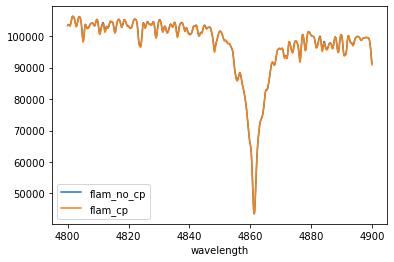

In [8]:
sample_and_plot_age( \
    age_mil=11, \
    min_wavelength=4800.0, \
    max_wavelength=4900.0 \
)